# Summary

In [1]:
%load_ext autoreload

import os
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import zscore

import flygenvectors.plotting as plotting
import flygenvectors.utils as utils
import flygenvectors.ssmutils as ssmutils
import flygenvectors.data as dataUtils
from flygenvectors.dlc import DLCLabels

In [2]:
plot_dark = False

sns.set_context('talk')
if plot_dark:
    plt.style.use('dark_background')
#     cmap_rasters = 'inferno'
    cmap_rasters = 'afmhot'
else:
    sns.set_style('white')
    cmap_rasters = 'Greys'

# 1. Load and preprocess data

In [3]:
# options
# expt_id = '190424_f3'  # (run+feed)
# expt_id = '180824_f3r1'
# expt_id = '2019_06_26_fly2'
# expt_id = '2019_06_28_fly2'
# expt_id = '2019_06_30_fly1'
expt_id = '2019_07_01_fly2'

# preprocessing directives
preprocess_list = {
    #'interpolate_labels': {'thresh': 0.8, 'window': 3}, # "bad" labels replaced with avg of neighboring "good" labels
    # 'standardize': {}, # zscore labels
    'unitize': {}, # scale labels in [0, 1]
    #'filter': {'type': 'median', 'window_size': 3},
    'filter': {'type': 'savgol', 'window_size': 5, 'order': 2},
    #'remove_bad_runs': {'thresh': 0.8, 'min_length': 10} # remove runs where at least one label is "bad"
}
do_fit_differences = False  # fit label differences rather than original labels

# load and preprocess dlc labels
dlc_obj = DLCLabels(expt_id, algo='dgp')
# dlc_obj.load_from_csv()
dlc_obj.load_from_mat()
dlc_obj.preprocess(preprocess_list)

# split labels into train/test/val
# dlc_obj.extract_runs_by_likelihood(
#     likelihoods=dlc_obj.labels['l'], l_thresh=0.0, min_length=100, max_length=500, 
#     skip_idxs=dlc_obj.skip_idxs)
dlc_obj.extract_runs_by_length(max_length=1000)
dlc_obj.split_labels(
    dtypes=['train', 'test', 'val'], dtype_lens=[9, 0, 1], diff=do_fit_differences)

# define model dir based on preprocessing
model_dir = 'dlc-arhmm'
if 'filter' in preprocess_list.keys():
    if preprocess_list['filter']['type'] == 'median':
        model_dir += '-median-%i' % preprocess_list['filter']['window_size']
    elif preprocess_list['filter']['type'] == 'savgol':
        model_dir += '-savgol-%i-%i' % (
            preprocess_list['filter']['window_size'], preprocess_list['filter']['order'])
    else: 
        raise NotImplementedError
if do_fit_differences:
    model_dir += '-diff'
print('\nsaving models in the following directory: "%s"' % model_dir)

loading labels from /media/mattw/data/flygenvectors/2019_07_01_fly2/crops_labels...done
total time points: 192980
unitizing labels...done
extracting runs of length 1000...done
extracted 193 runs for a total of 192980 time points
splitting labels into ['train', 'test', 'val']...done
	train: 173980 time points in 174 trials
	test: 0 time points in 0 trials
	val: 19000 time points in 19 trials

saving models in the following directory: "dlc-arhmm"


# play with kmeans init

In [30]:
from sklearn.cluster import KMeans
K = 5
lags = 3
datas = dlc_obj.labels_dict['train']
Ts = [data.shape[0] for data in datas]
km = KMeans(K)
if False:   
    km.fit(np.vstack(datas))
    zs = np.split(km.labels_, np.cumsum(Ts)[:-1])
else:
    km.fit(np.diff(np.vstack(datas), axis=0))
    zs = np.split(np.concatenate([[0], km.labels_]), np.cumsum(Ts)[:-1])
zs = [z[:-lags] for z in zs] 

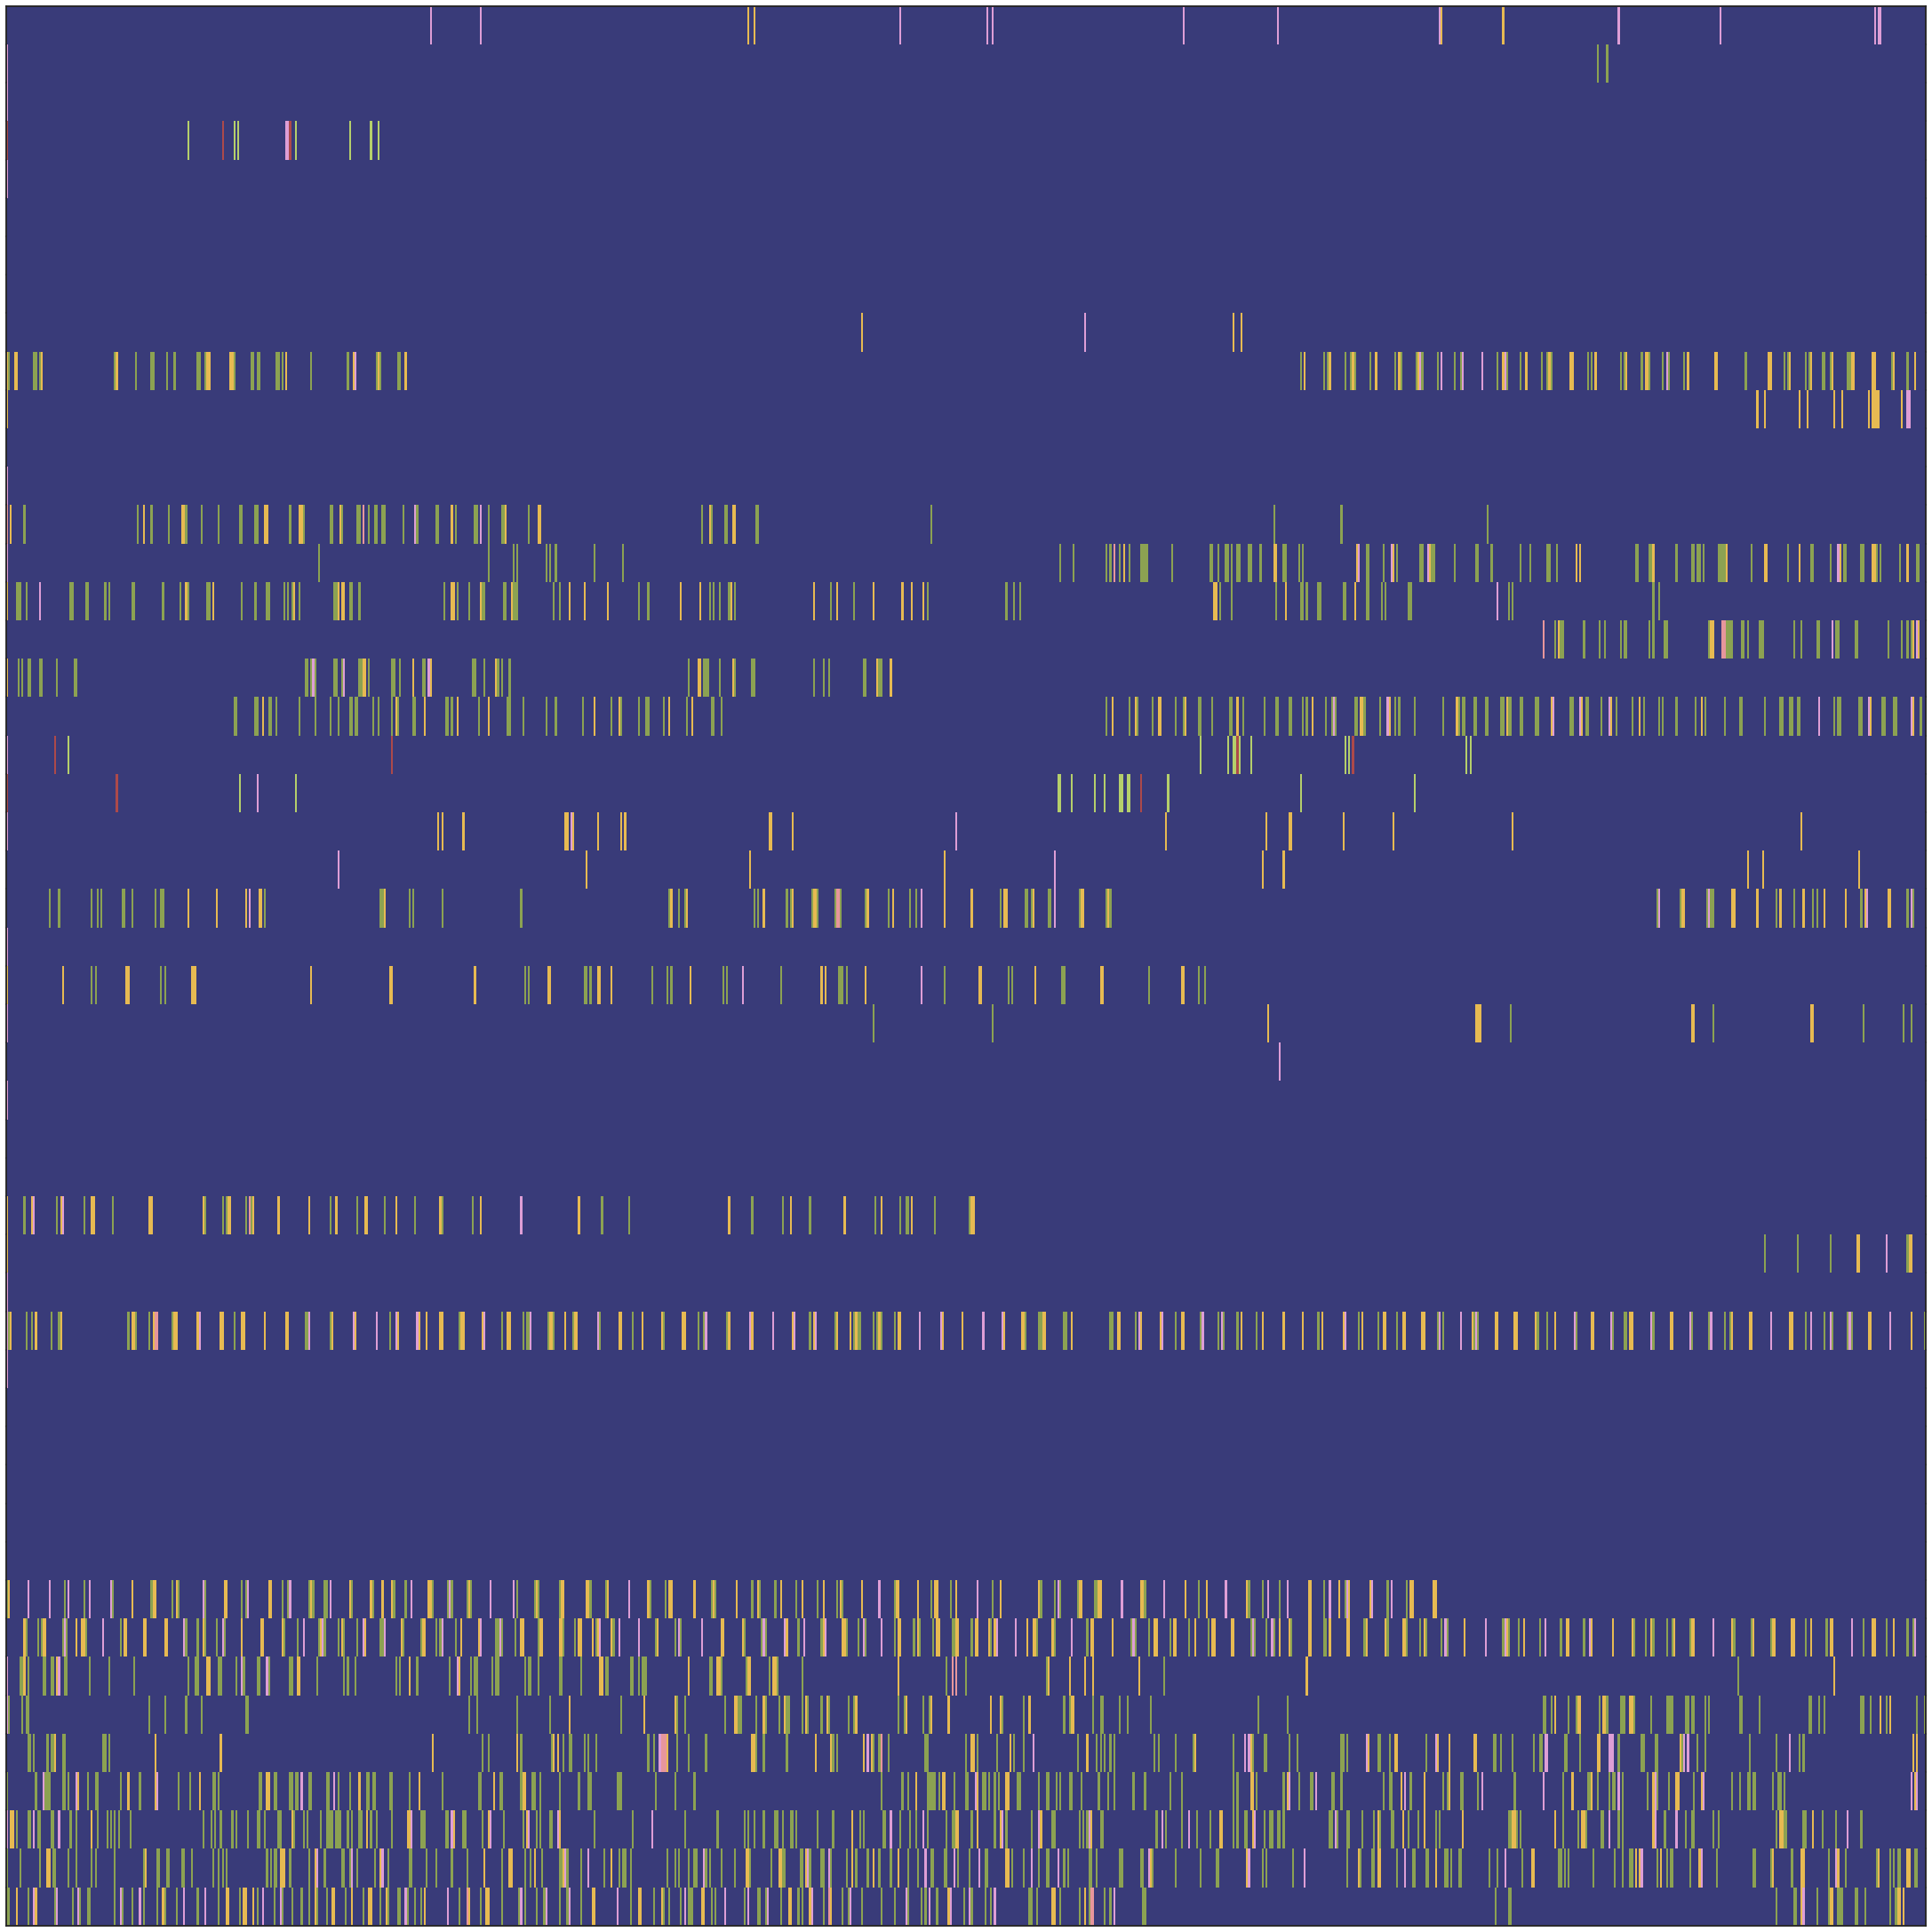

In [31]:
mult = 50
fig, axes = plt.subplots(mult, 1, figsize=(30, 0.6 * mult))
for i, ax in enumerate(axes):
    ax.imshow(zs[i][None, :], aspect='auto', cmap='tab20b')
    ax.set_xticks([]); ax.set_yticks([])
    if not ax.is_first_row():
        ax.spines['top'].set_visible(False)
    if not ax.is_last_row():
        ax.spines['bottom'].set_visible(False)
plt.tight_layout(pad=0)

# play with single-still-state init

In [15]:
from scipy.signal import savgol_filter
# datas = dlc_obj.get_label_array()
x1 = datas[:, 14]
x2 = savgol_filter(x1, 5, 2)

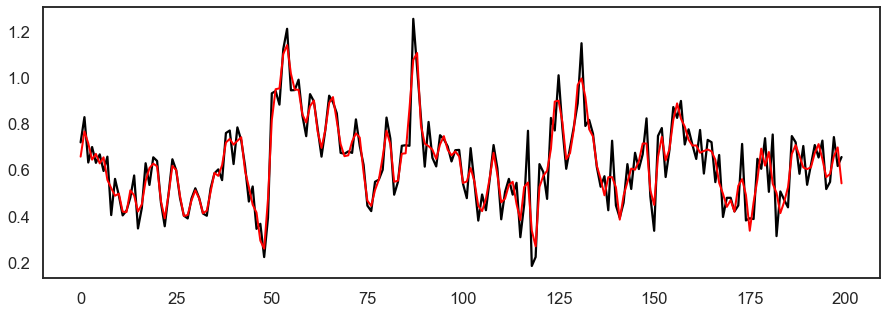

In [16]:
slc = slice(150000, 150200)
plt.figure(figsize=(15, 5))
plt.plot(x1[slc], 'k')
plt.plot(x2[slc], 'r', linewidth=2)
plt.show()

In [87]:
from sklearn.decomposition import PCA

datas = dlc_obj.labels_dict['train']
Ts = [data.shape[0] for data in datas]

D = datas[0].shape[1]
K = 5

# pca on motion energy
datas_filt = np.copy(datas)
for dtmp in datas_filt:
    for i in range(dtmp.shape[1]):
        dtmp[:, i] = savgol_filter(dtmp[:, i], 5, 2)
pca = PCA(1)
me = np.square(np.diff(np.vstack(datas_filt), axis=0))
xs = pca.fit_transform(np.concatenate([np.zeros((1, D)), me], axis=0))[:, 0]
xs = xs / np.max(xs)

# threshold data to get moving/non-moving
thresh = 0.01
zs = np.copy(xs)
zs[xs < thresh] = 0
zs[xs >= thresh] = 1

# cluster moving data
km = KMeans(K-1)
km.fit(np.vstack(datas)[zs==1])
zs[zs==1] = km.labels_ + 1

# split
zs = np.split(zs, np.cumsum(Ts)[:-1])
xss = np.split(xs, np.cumsum(Ts)[:-1])

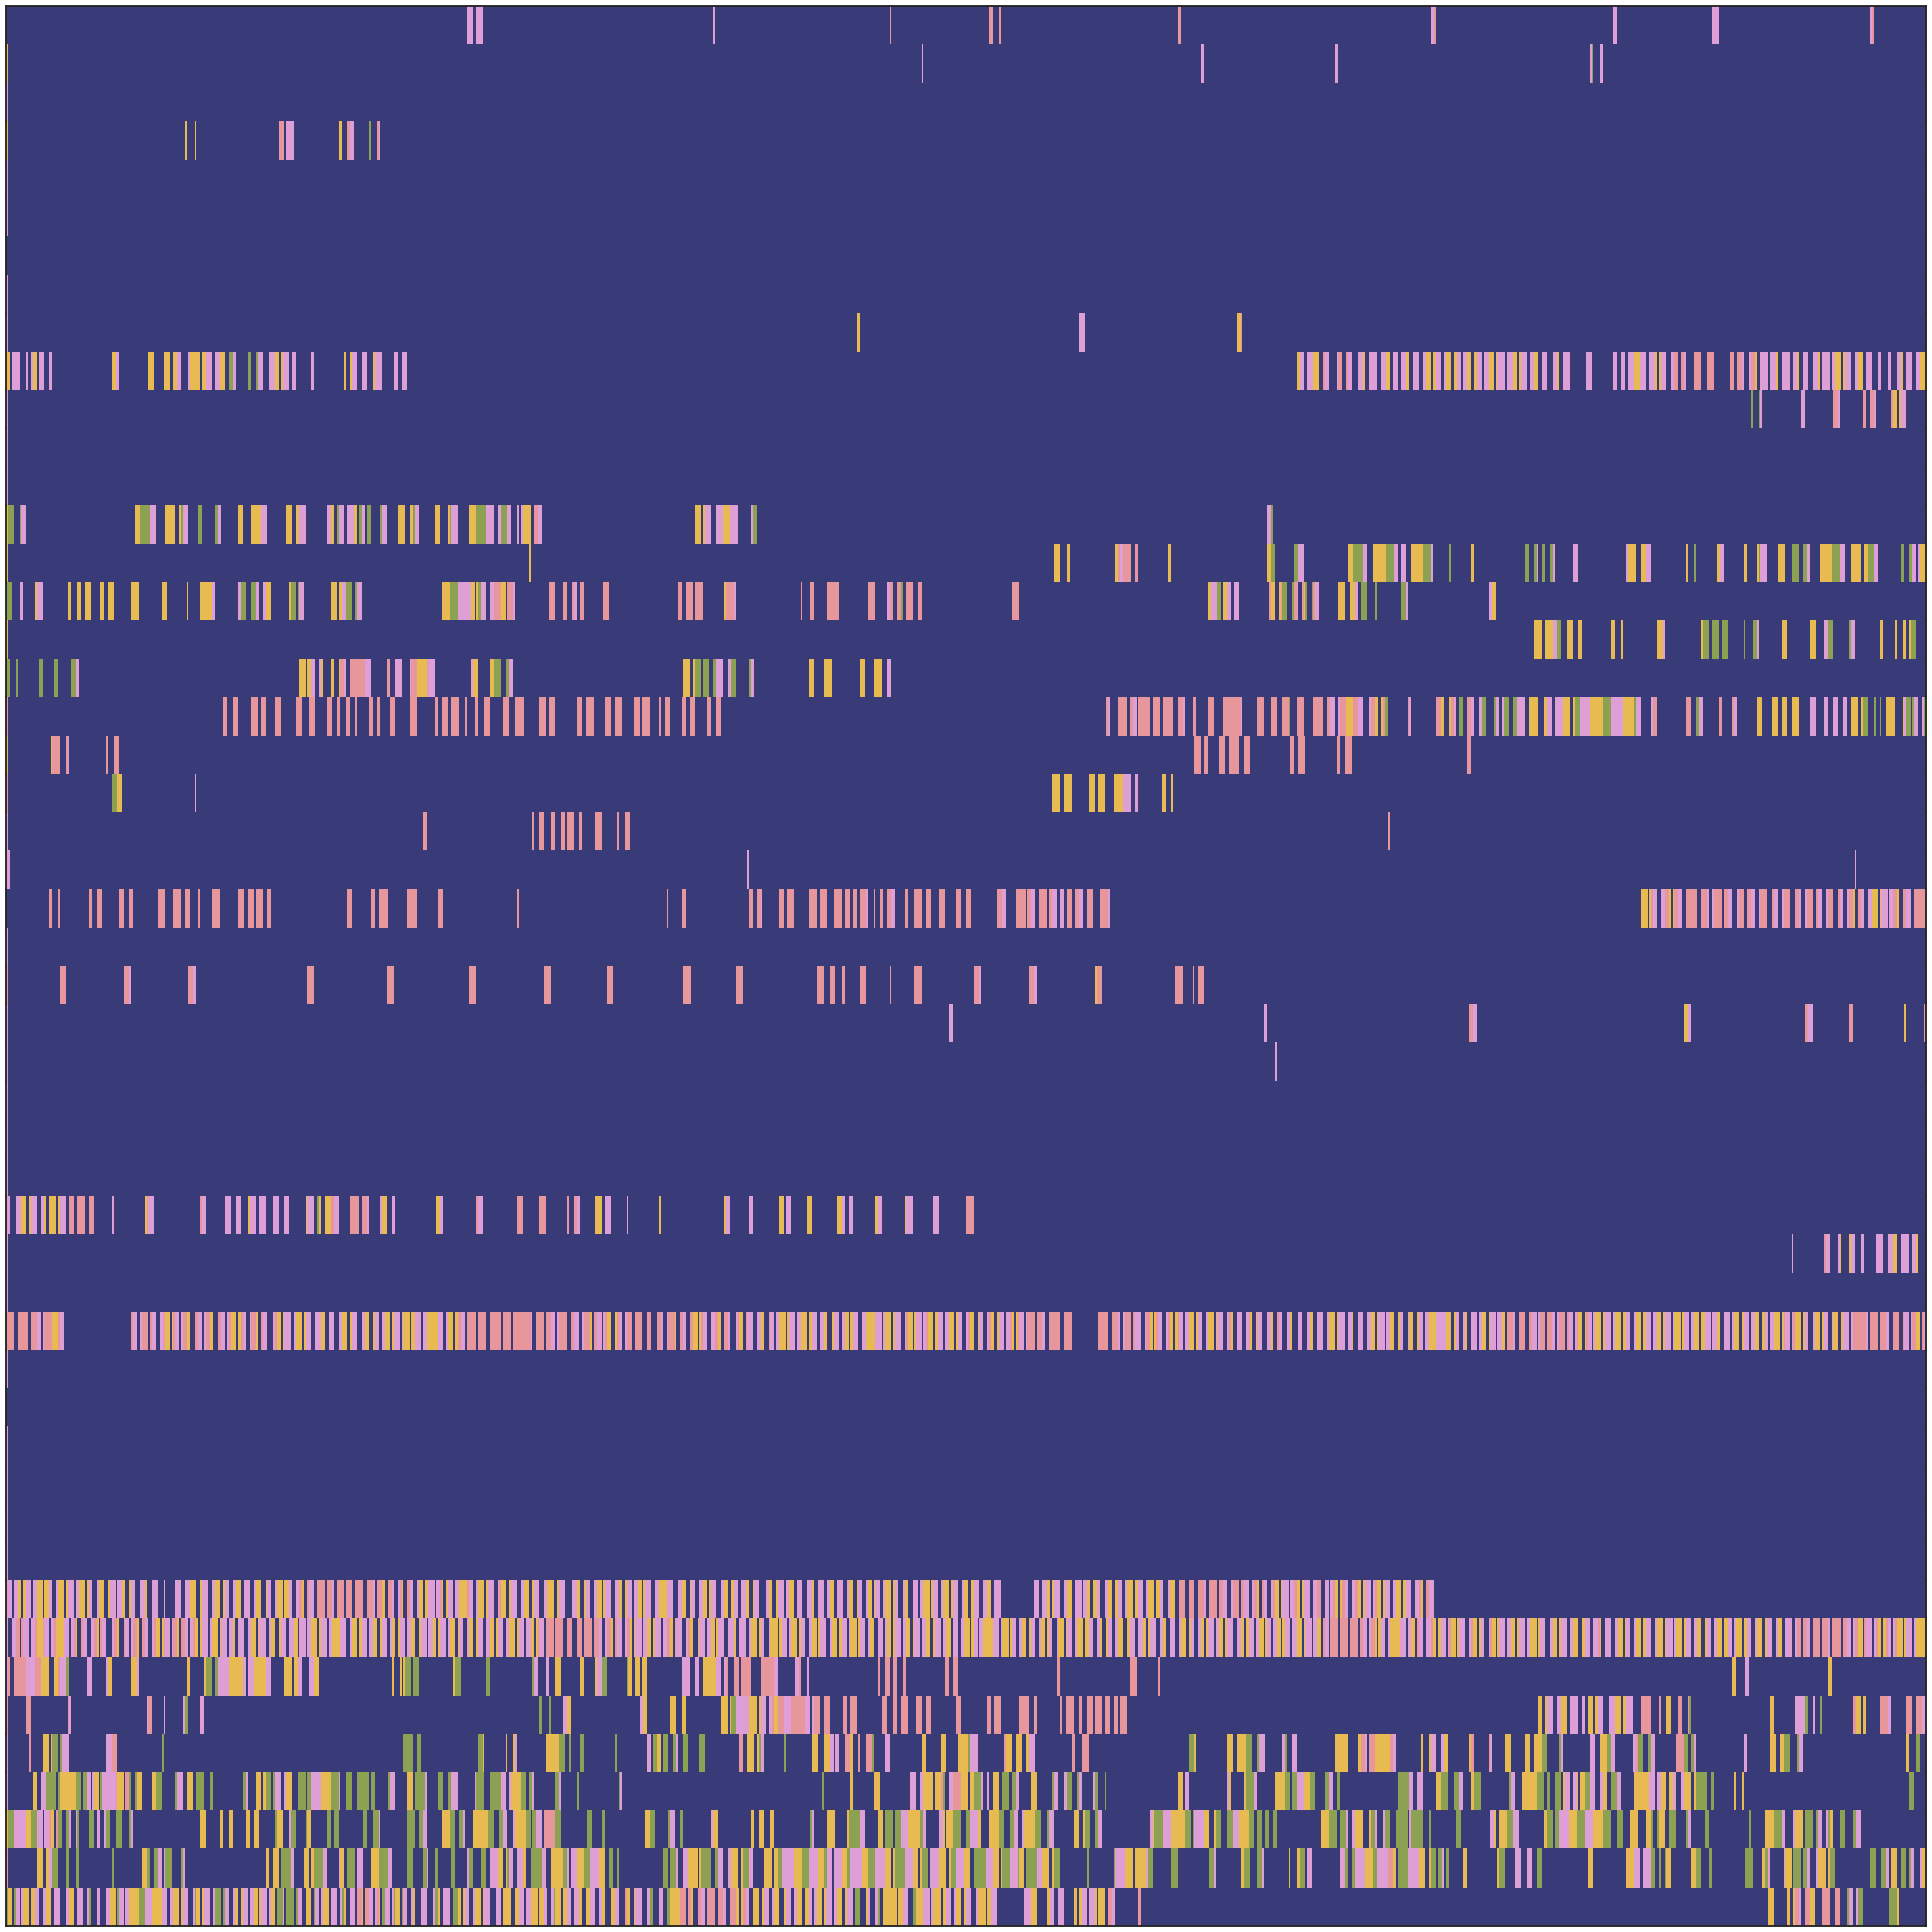

In [88]:
mult = 50
fig, axes = plt.subplots(mult, 1, figsize=(30, 0.6 * mult))
for i, ax in enumerate(axes):
    ax.imshow(zs[i][None, :], aspect='auto', cmap='tab20b')
#     ax.imshow(xss[i].T, aspect='auto', cmap='Reds')
#     ax.plot(xss[i])
    ax.set_xticks([]); ax.set_yticks([])
    if not ax.is_first_row():
        ax.spines['top'].set_visible(False)
    if not ax.is_last_row():
        ax.spines['bottom'].set_visible(False)
plt.tight_layout(pad=0)

# play with single-still-state init (arhmm)

In [69]:
from sklearn.decomposition import PCA

datas = dlc_obj.labels_dict['train']

Ts = [data.shape[0] for data in datas]
D_ = 4
K = 2
lags = 1

# pca on motion energy
pca = PCA(D_)
xs = pca.fit_transform(np.vstack(datas))
xs = np.split(xs, np.cumsum(Ts)[:-1])

model_init = HMM(
    K=K, D=D_, M=0, transitions='standard', observations='ar',
    observations_kwargs={'lags': lags})
init_model('custom', model_init, xs)
lps = model_init.fit(
    xs, inputs=None, method='em', num_iters=100, tolerance=1e-2, 
    initialize=False, transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})
inputs_tr = [None] * len(data_tr)
zs = [model_init.most_likely_states(x, u)[lags:] for x, u in zip(xs, inputs_tr)]

In [82]:
model_init.permute([1, 0])

In [86]:
np.mean(np.square(model_init.observations.As[0]-np.eye(4)))

0.0003131854794990923

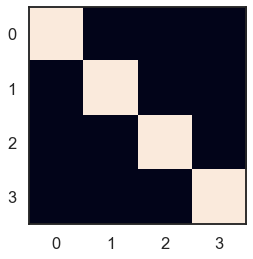

In [84]:
plt.figure()
plt.imshow(model_init.observations.As[1])
plt.show()

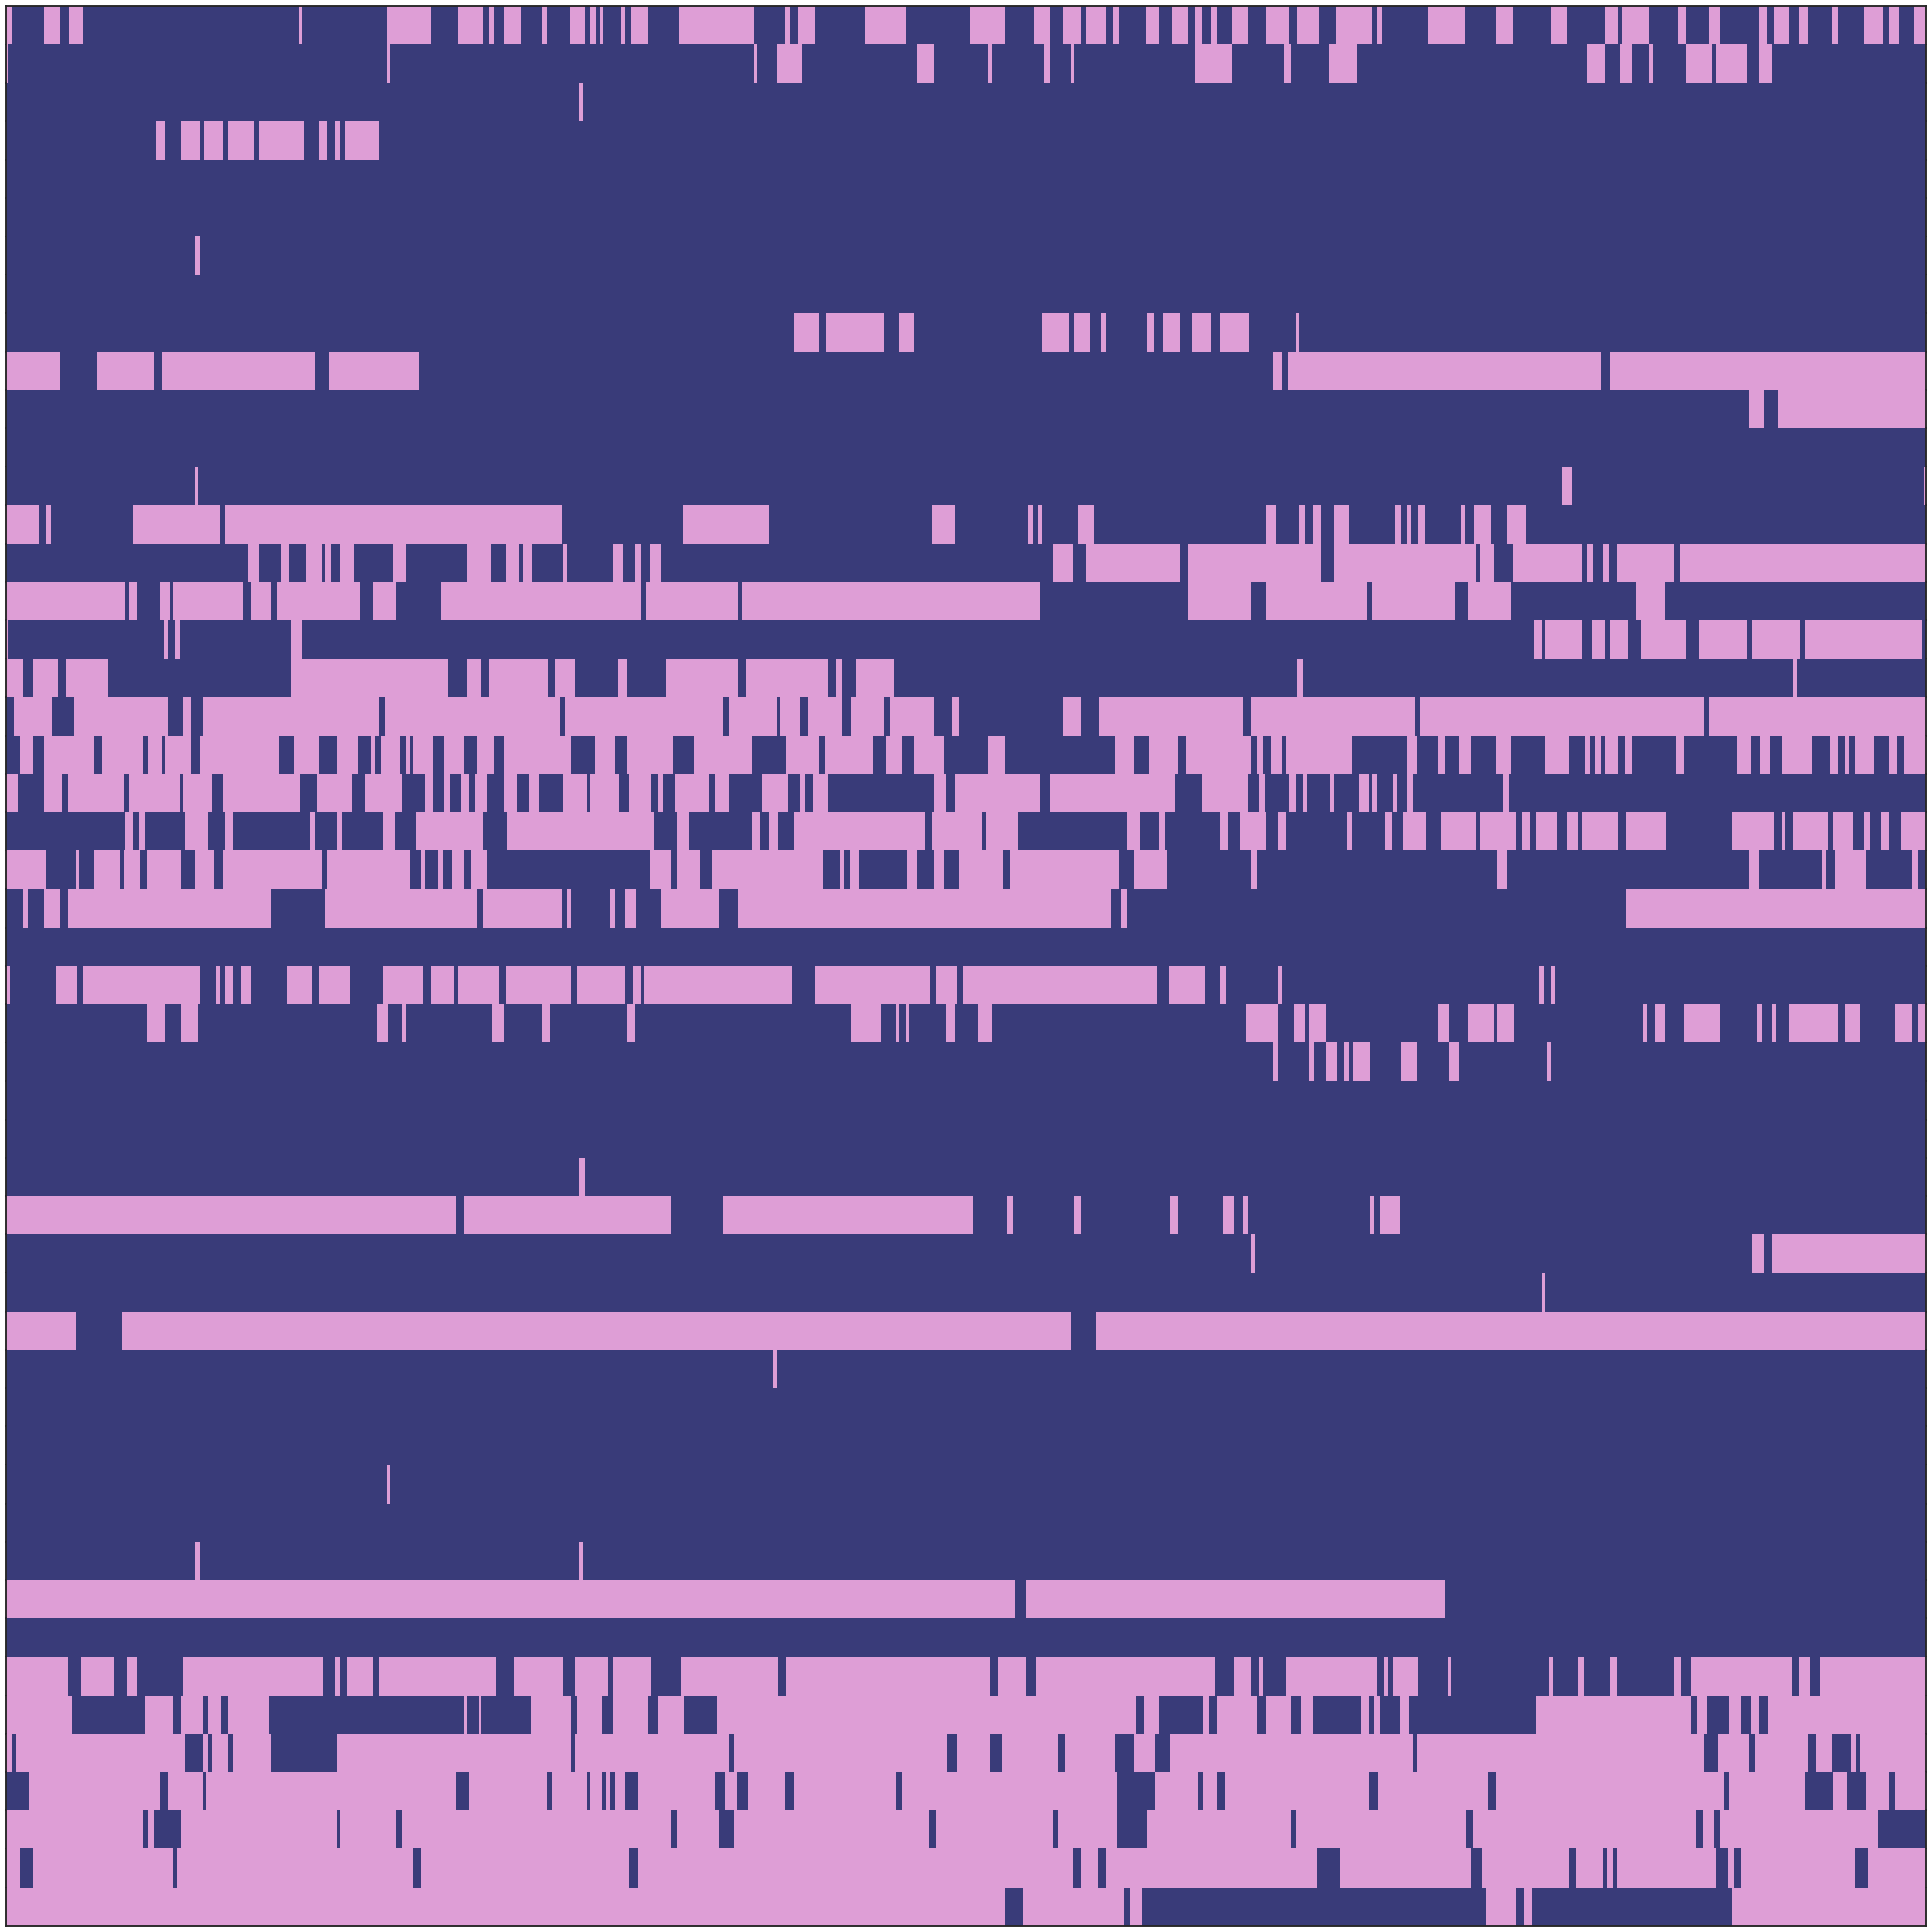

In [70]:
mult = 50
fig, axes = plt.subplots(mult, 1, figsize=(30, 0.6 * mult))
for i, ax in enumerate(axes):
    ax.imshow(zs[i][None, :], aspect='auto', cmap='tab20b')
#     ax.imshow(xss[i].T, aspect='auto', cmap='Reds')
#     ax.plot(xss[i])
    ax.set_xticks([]); ax.set_yticks([])
    if not ax.is_first_row():
        ax.spines['top'].set_visible(False)
    if not ax.is_last_row():
        ax.spines['bottom'].set_visible(False)
plt.tight_layout(pad=0)

# 2. Fit dynamics

In [18]:
from ssm.regression import fit_linear_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter

def init_model(init_type, model, datas):
    
    Ts = [data.shape[0] for data in datas]
    K = model.K
    D = model.observations.D
    lags = model.observations.lags

    # --------------------------
    # initialize discrete states
    # --------------------------
    if init_type == 'random':
        
        zs = [np.random.choice(K, size=T-lags) for T in Ts]
        
    elif init_type == 'kmeans':

        km = KMeans(K)
        km.fit(np.vstack(datas))
        zs = np.split(km.labels_, np.cumsum(Ts)[:-1])
        zs = [z[lags:] for z in zs]
        
    elif init_type == 'arhmm':
        
        # pca on motion energy
        
        D_ = 4       
        pca = PCA(D_)
        xs = pca.fit_transform(np.vstack(datas))
        xs = np.split(xs, np.cumsum(Ts)[:-1])

        model_init = HMM(
            K=2, D=D_, M=0, transitions='standard', observations='ar',
            observations_kwargs={'lags': 1})
        init_model('pca_me', model_init, xs)
        model_init.fit(
            xs, inputs=None, method='em', num_iters=100, tolerance=1e-2, 
            initialize=False, transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})
        
        # make still state 0th state
        mses = [
            np.mean(np.square(model_init.observations.As[i]-np.eye(D_))) for i in range(2)]
        if mses[1] < mses[0]:
            # permute states
            model_init.permute([1, 0])
        moving_state = 1
        
        inputs_tr = [None] * len(data_tr)
        zs = [model_init.most_likely_states(x, u) for x, u in zip(xs, inputs_tr)]
        zs = np.concatenate(zs, axis=0)
                
        # cluster moving data
        km = KMeans(K-1)
        km.fit(np.vstack(datas)[zs==moving_state])
        zs[zs==moving_state] = km.labels_ + 1

        # split
        zs = np.split(zs, np.cumsum(Ts)[:-1])
        zs = [z[lags:] for z in zs]  # remove the ends
        
    elif init_type == 'pca_me':

        # pca on motion energy
        datas_filt = np.copy(datas)
        for dtmp in datas_filt:
            for i in range(dtmp.shape[1]):
                dtmp[:, i] = savgol_filter(dtmp[:, i], 5, 2)
        pca = PCA(1)
        me = np.square(np.diff(np.vstack(datas_filt), axis=0))
        xs = pca.fit_transform(np.concatenate([np.zeros((1, D)), me], axis=0))[:, 0]
        xs = xs / np.max(xs)

        # threshold data to get moving/non-moving
        thresh = 0.01
        zs = np.copy(xs)
        zs[xs < thresh] = 0
        zs[xs >= thresh] = 1

        # cluster moving data
        km = KMeans(K-1)
        km.fit(np.vstack(datas)[zs==1])
        zs[zs==1] = km.labels_ + 1

        # split
        zs = np.split(zs, np.cumsum(Ts)[:-1])
        zs = [z[lags:] for z in zs]  # remove the ends
        
    else:
        raise NotImplementedError('Invalid "init_type" of "%s"' % init_type)
        
    # ------------------------
    # estimate dynamics params
    # ------------------------
    # Initialize the weights with linear regression       
    Sigmas = []
    for k in range(K):
        ts = [np.where(z == k)[0] + lags for z in zs]
        Xs = [np.column_stack([data[t-l-1] for l in range(lags)]) 
              for t, data in zip(ts, datas)]
        ys = [data[t] for t, data in zip(ts, datas)]

        # Solve the linear regression
        coef_, intercept_, Sigma = fit_linear_regression(Xs, ys)
        model.observations.As[k] = coef_[:, :D * lags]
        model.observations.Vs[k] = coef_[:, D * lags:]
        model.observations.bs[k] = intercept_
        Sigmas.append(Sigma)

    # Set the variances all at once to use the setter
    model.observations.Sigmas = np.array(Sigmas)

### ARHMM - how many discrete states?

In [43]:
import copy
from ssm import HMM

K = 20
transitions = 'standard'
observations = 'diagonal_robust_ar' # 'diagonal_ar' #'ar'
observation_kwargs = {'lags': 2}
init_types = ['random', 'kmeans', 'pca_me', 'arhmm']
# init_types = ['arhmm']

data_tr=dlc_obj.labels_dict['train']
data_val=dlc_obj.labels_dict['val']
data_test=dlc_obj.labels_dict['test']
D = dlc_obj.labels_dict['train'][0].shape[1]

model_results = {init_type: None for init_type in init_types}
for init_type in init_types:

    model = HMM(
        K=K, D=D, M=0, transitions=transitions, observations=observations,
        observation_kwargs=observation_kwargs)

    init_model(init_type, model, data_tr)

    # run EM; specify tolerances for overall convergence and each M-step's
    # convergence
    lps = model.fit(
        data_tr, inputs=None, method='em', num_iters=100, tolerance=1e-2, 
        initialize=False, transitions_mstep_kwargs={'optimizer': 'lbfgs', 'tol': 1e-3})

    # compute stats
    ll_val = model.log_likelihood(data_val, inputs=None)
    ll_test = model.log_likelihood(data_test, inputs=None)

    # sort states by usage
    inputs_tr = [None] * len(data_tr)
    states_tr = [model.most_likely_states(x, u) for x, u in zip(data_tr, inputs_tr)]
    usage = np.bincount(np.concatenate(states_tr), minlength=K)
    model.permute(np.argsort(-usage))
    #states_tr = [model.most_likely_states(x, u) for x, u in zip(data_tr, inputs_tr)]

    # combine results
    model_results[init_type] = {
        'model': copy.deepcopy(model),
        'states_tr': states_tr,
        'lps': lps,
        'll_val': ll_val,
        'll_test': ll_test}

/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [1e-08,100] to 7.663698342597058e-09.
  "bounds [{},{}] to {}.".format(nu_min, nu_max, nu))
/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [1e-08,100] to 4.609493675644671e-09.
  "bounds [{},{}] to {}.".format(nu_min, nu_max, nu))
/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [1e-08,100] to 4.601449887786657e-09.
  "bounds [{},{}] to {}.".format(nu_min, nu_max, nu))
/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [1e-08,100] to 4.599187919396286e-09.
  "bounds [{},{}] to {}.".format(nu_min, nu_max, nu))
/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed po

/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [1e-08,100] to 4.609245429776365e-09.
  "bounds [{},{}] to {}.".format(nu_min, nu_max, nu))
/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [1e-08,100] to 4.609382653342209e-09.
  "bounds [{},{}] to {}.".format(nu_min, nu_max, nu))
/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [1e-08,100] to 4.60949811653677e-09.
  "bounds [{},{}] to {}.".format(nu_min, nu_max, nu))
/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed point grew beyond bounds [1e-08,100] to 4.609597814564381e-09.
  "bounds [{},{}] to {}.".format(nu_min, nu_max, nu))
/home/mattw/Dropbox/github/ssm/ssm/regression.py:465: UserWarning: generalized_newton_studentst_dof fixed poi

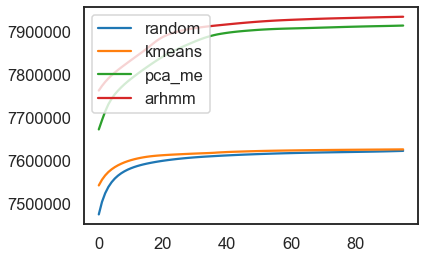

In [82]:
plt.figure()
for i in init_types:
    plt.plot(model_results[i]['lps'][5:], label=i)
plt.legend()
plt.show()

In [87]:
all_results = {
    'random': {20: model_results['random']},
    'kmeans': {20: model_results['kmeans']},
    'pca_me': {20: model_results['pca_me']},
    'arhmm': {20: model_results['arhmm']},
}

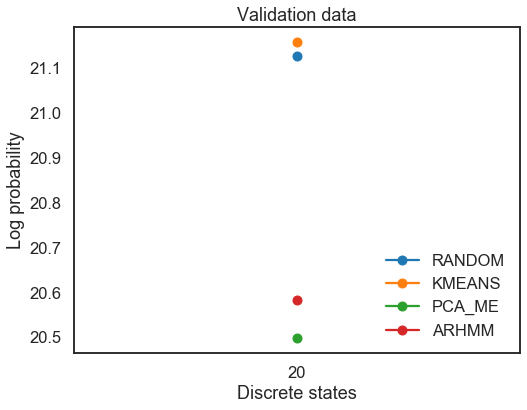

In [88]:
fig = plotting.plot_validation_likelihoods(
    all_results=all_results, 
    T_val=np.sum([d.shape[0] for d in dlc_obj.labels_dict['val']]))
plt.legend(loc='lower right', frameon=False)

# 3. Probe learned dynamics

In [90]:
all_results = model_results

In [91]:
# choose model
model_name = 'kmeans'
dtype = 'train'
arhmm = all_results[model_name]['model']

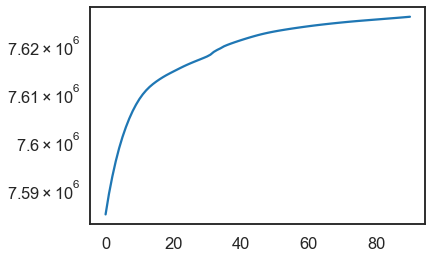

In [92]:
plt.figure()
plt.plot(all_results[model_name]['lps'][10:])
plt.yscale('log')
plt.show()

In [93]:
# get most likely states
states_all = [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict[dtype]]

# collect all state snippets
indx_snippets = ssmutils.extract_state_runs(
    states_all, dlc_obj.idxs_dict[dtype], min_length=2)

# get lengths of snippets
state_lengths = [[] for _ in range(K)]
for k, k_indxs in enumerate(indx_snippets):
    for k_indx in k_indxs:
        state_lengths[k].append(len(k_indx))     
state_lengths = [np.array(state_lengths[k]) for k in range(K)]

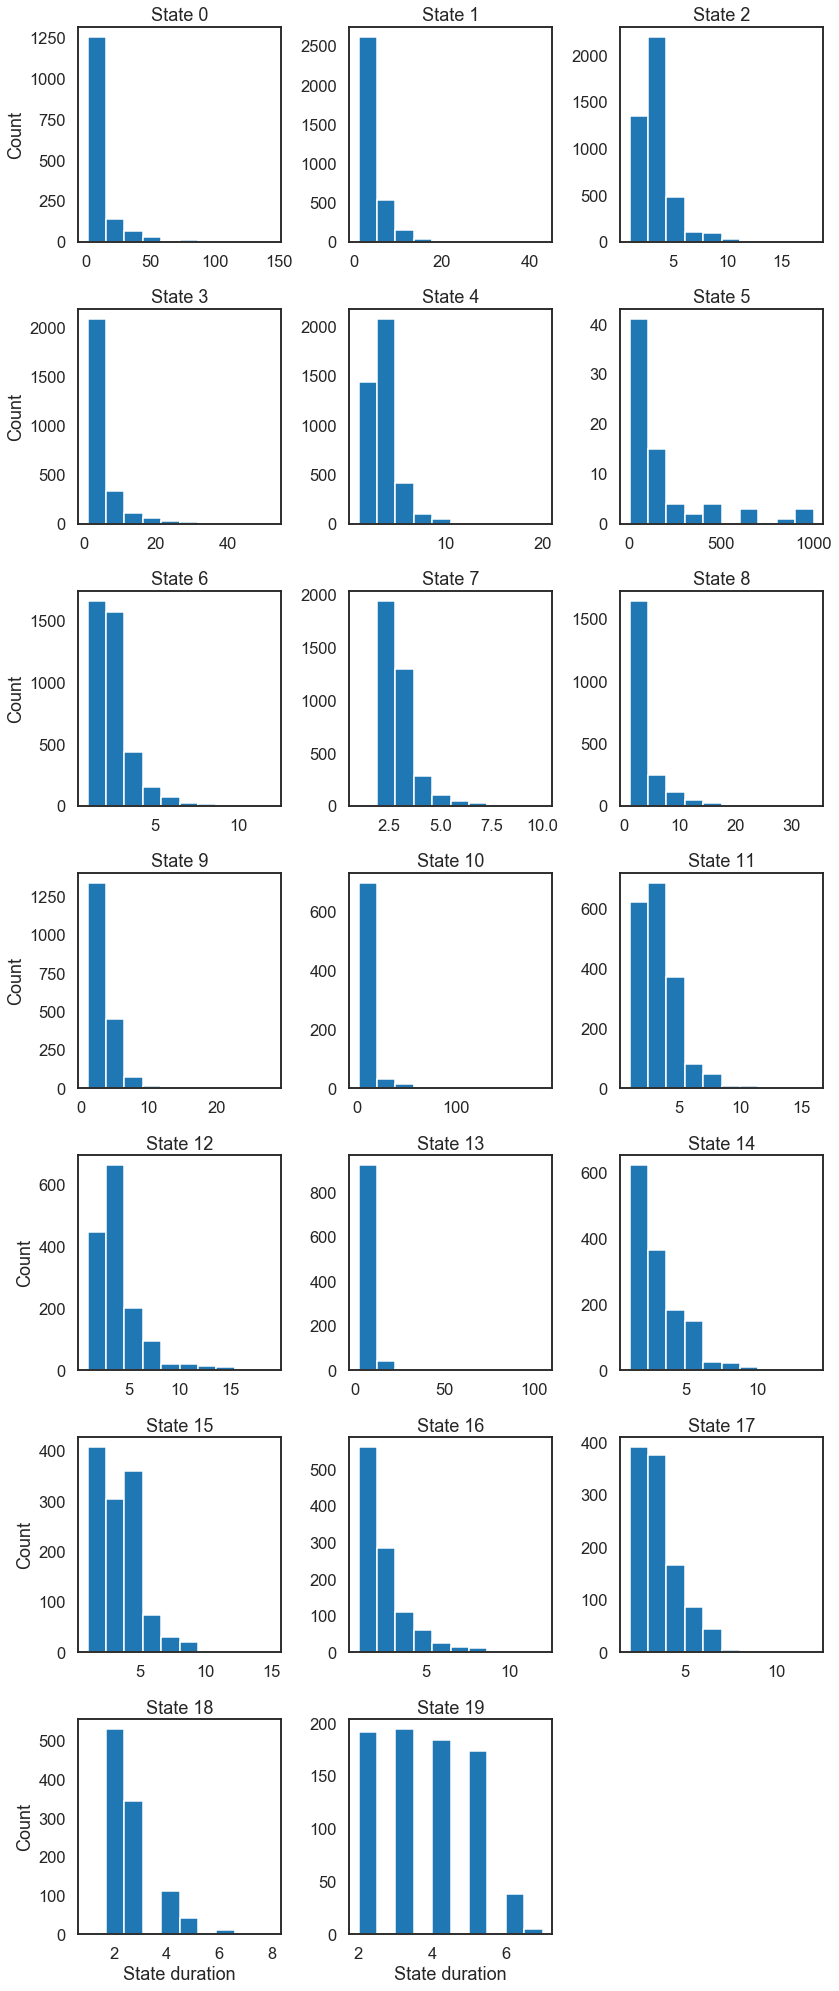

In [94]:
# plot distribution of state durations
n_cols = 3
n_rows = np.ceil(K / n_cols)

fig = plt.figure(figsize=(4 * n_cols, 4 * n_rows))

for i, slens in enumerate(state_lengths):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(slens) #, range=(0, 20))
    plt.title(str('State %i' % i))
    if plt.gca().is_first_col():
        plt.ylabel('Count')
    if plt.gca().is_last_row():
        plt.xlabel('State duration')
plt.tight_layout()
plt.show()

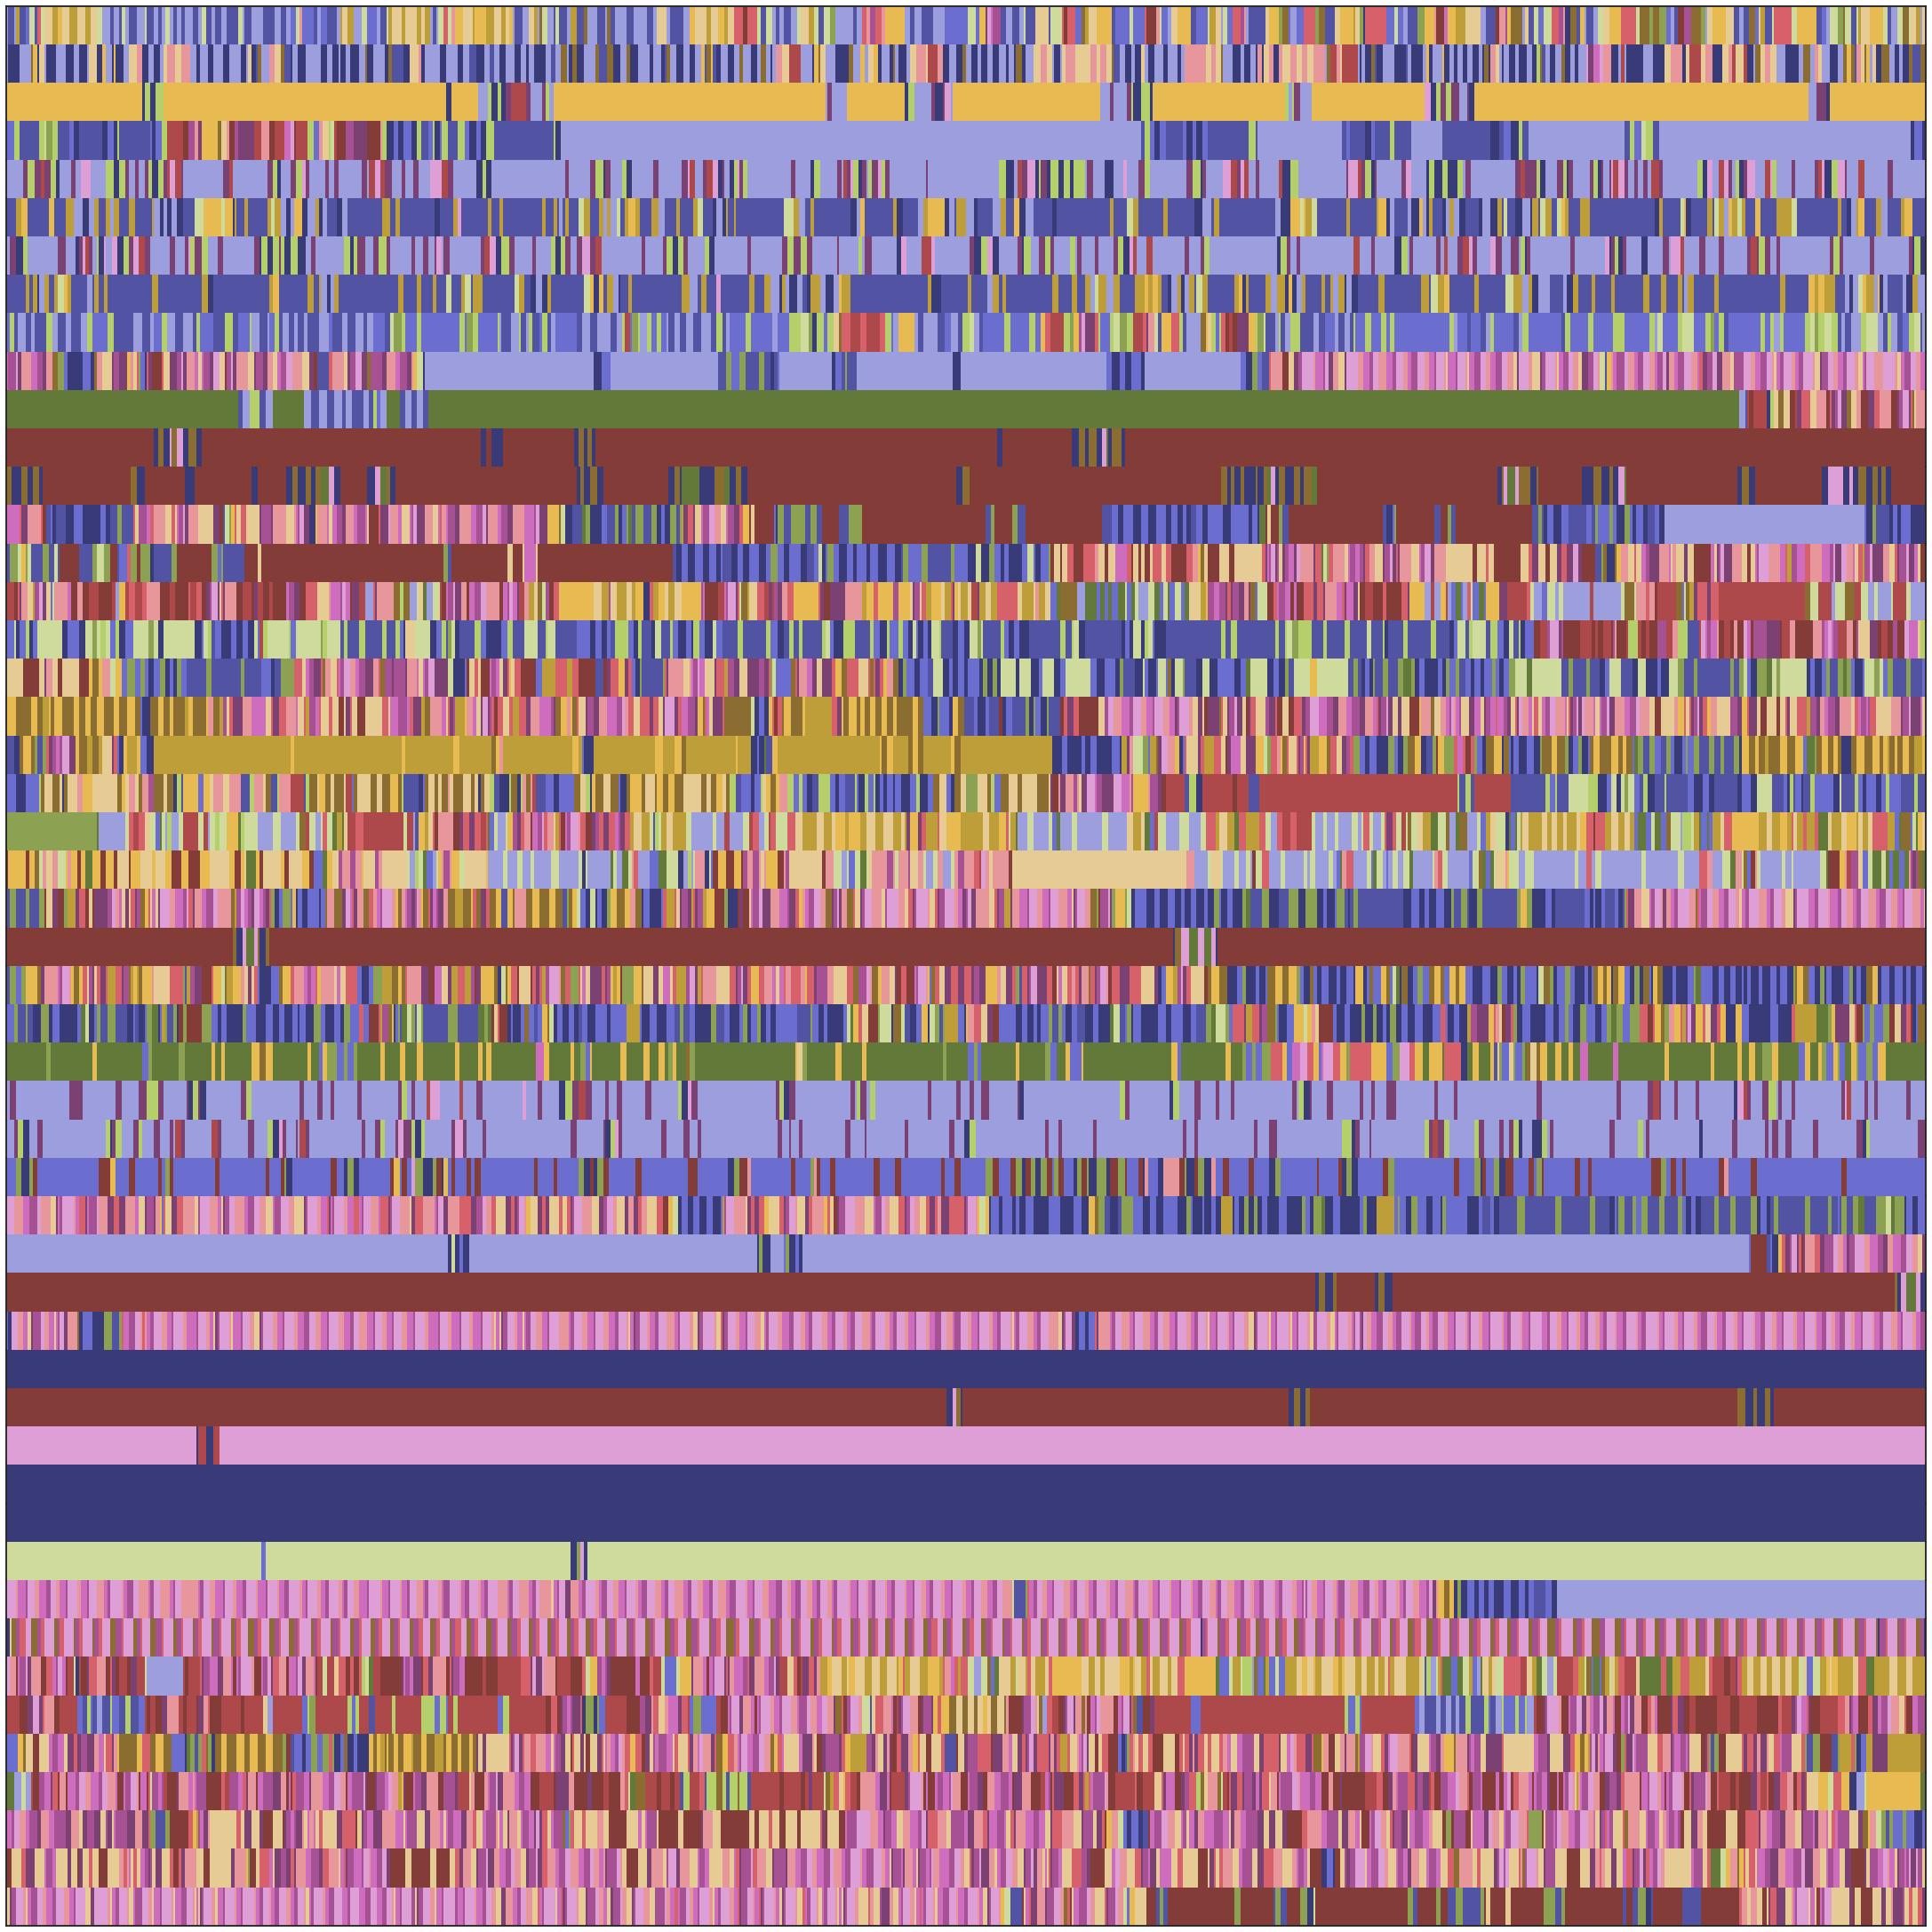

In [95]:
mult = 50
fig, axes = plt.subplots(mult, 1, figsize=(30, 0.6 * mult))
for i, ax in enumerate(axes):
    ax.imshow(states_all[i][None, :], aspect='auto', cmap='tab20b')
#     ax.imshow(xss[i].T, aspect='auto', cmap='Reds')
#     ax.plot(xss[i])
    ax.set_xticks([]); ax.set_yticks([])
    if not ax.is_first_row():
        ax.spines['top'].set_visible(False)
    if not ax.is_last_row():
        ax.spines['bottom'].set_visible(False)
plt.tight_layout(pad=0)

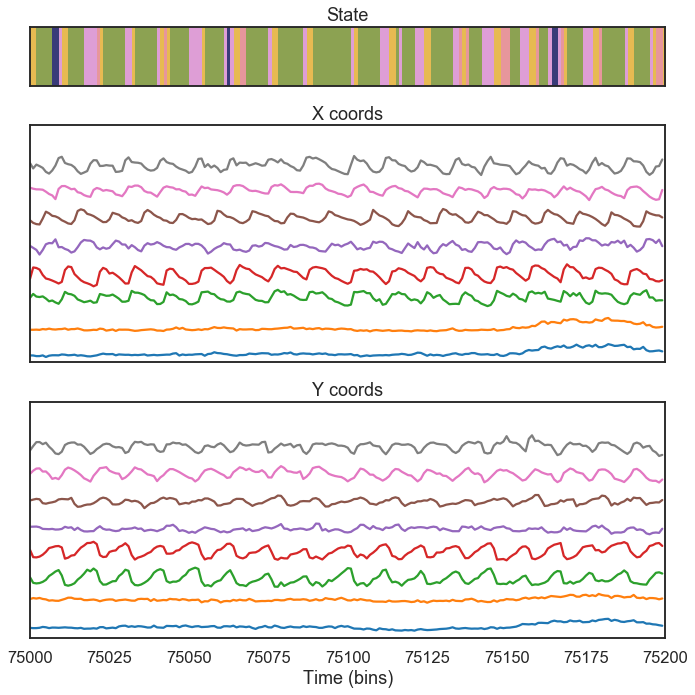

In [76]:
# infer all states and plot dlc lablels
# %load_ext autoreload
# import flygenvectors.plotting as plotting

states_ = arhmm.most_likely_states(dlc_obj.get_label_array())
# slc = (0, 1000)
slc = (75000, 75200)
fig = plotting.plot_dlc_arhmm_states(
    dlc_labels=dlc_obj.labels, state_probs=None, states=states_, slc=slc, m=2)

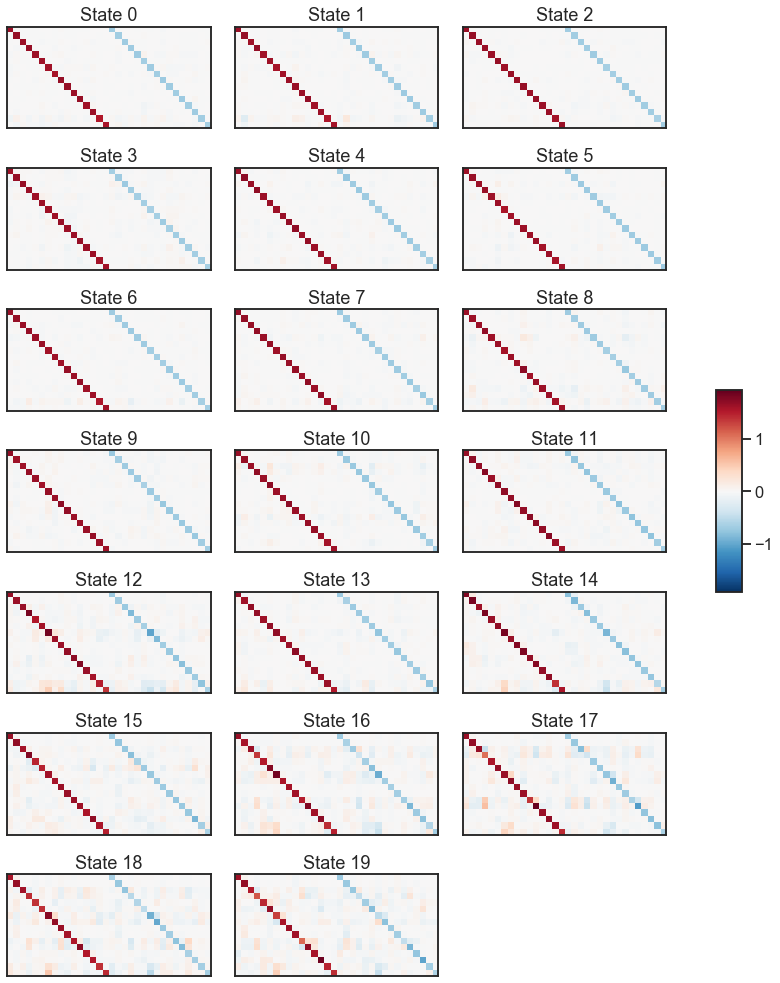

In [80]:
# choose model
# K = 20
# n_lags = 3
# model_name = str('arhmm-%i' % n_lags)
# dtype = 'train'
# arhmm = all_results[model_name][K]['model']
# # get most likely states
# states_all = [arhmm.most_likely_states(d) for d in dlc_obj.labels_dict[dtype]]
# fig = plotting.plot_covariance_matrices(arhmm)
fig = plotting.plot_dynamics_matrices(arhmm, deridge=False)

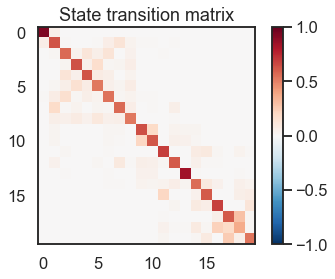

In [78]:
fig = plotting.plot_state_transition_matrix(arhmm, deridge=False)